# Libraries

In [1]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hypothesis Testing, Measures of Shape
from scipy.stats import kruskal, skew, kurtosis

from sklearn.preprocessing import StandardScaler

# Model
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import log_loss
# Shap
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# Self Functions

In [2]:
# Grab Column Names
def grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False):
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "datetime64[ns]"]

    #cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    cat_cols = dataframe.select_dtypes(["object", "category"]).columns.tolist()
    
    
    
    num_but_cat = [col for col in dataframe.select_dtypes(["float", "integer"]).columns if dataframe[col].nunique() < cat_th]

    cat_but_car = [col for col in dataframe.select_dtypes(["object", "category"]).columns if dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = dataframe.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'date_cols: {len(date_cols)}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')


    if show_date == True:
        return date_cols, cat_cols, cat_but_car, num_cols, num_but_cat
    else:
        return cat_cols, cat_but_car, num_cols, num_but_cat
    
    
# Missing Value
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")
    
    
# Categorical Variables & Target
def cat_analyzer(dataframe, variable, target = None):
    print(variable)
    if target == None:
        print(pd.DataFrame({
            "COUNT": dataframe[variable].value_counts(),
            "RATIO": dataframe[variable].value_counts() / len(dataframe)}), end="\n\n\n")
    else:
        temp = dataframe[dataframe[target].isnull() == False]
        print(pd.DataFrame({
            "COUNT":dataframe[variable].value_counts(),
            "RATIO":dataframe[variable].value_counts() / len(dataframe),
            "TARGET_COUNT":dataframe.groupby(variable)[target].count(),
            "TARGET_MEAN":temp.groupby(variable)[target].mean(),
            "TARGET_MEDIAN":temp.groupby(variable)[target].median(),
            "TARGET_STD":temp.groupby(variable)[target].std()}), end="\n\n\n")
        
        
# Numerical Variables
def corr_plot(data, remove=["Id"], corr_coef = "pearson", figsize=(20, 20)):
    if len(remove) > 0:
        num_cols2 = [x for x in data.columns if (x not in remove)]

    sns.set(font_scale=1.1)
    c = data[num_cols2].corr(method = corr_coef)
    mask = np.triu(c.corr(method = corr_coef))
    plt.figure(figsize=figsize)
    sns.heatmap(c,
                annot=True,
                fmt='.1f',
                cmap='coolwarm',
                square=True,
                mask=mask,
                linewidths=1,
                cbar=False)
    plt.show()

# Plot numerical variables
def num_plot(data, num_cols, remove=["Id"], hist_bins=10, figsize=(20, 4)):

    if len(remove) > 0:
        num_cols2 = [x for x in num_cols if (x not in remove)]

    for i in num_cols2:
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        data.hist(str(i), bins=hist_bins, ax=axes[0])
        data.boxplot(str(i), ax=axes[1], vert=False);
        try:
            sns.kdeplot(np.array(data[str(i)]))
        except:
            ValueError

        axes[1].set_yticklabels([])
        axes[1].set_yticks([])
        axes[0].set_title(i + " | Histogram")
        axes[1].set_title(i + " | Boxplot")
        axes[2].set_title(i + " | Density")
        plt.show()

# Get high correlated variables
def high_correlation(data, remove=['SK_ID_CURR', 'SK_ID_BUREAU'], corr_coef="pearson", corr_value = 0.7):
    if len(remove) > 0:
        cols = [x for x in data.columns if (x not in remove)]
        c = data[cols].corr(method=corr_coef)
    else:
        c = data.corr(method=corr_coef)

    for i in c.columns:
        cr = c.loc[i].loc[(c.loc[i] >= corr_value) | (c.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")
            
            
# CART FEATURE GENERATOR
def cart_feature_gen(model_type, dataframe, X, y, threshold = 1, suffix = None):
    # Remove NaN
    temp = dataframe[[X,y]].dropna()
    
    # Model Type
    if model_type == "reg":
        from sklearn.tree import DecisionTreeRegressor
        model = DecisionTreeRegressor()
    elif model_type == "class":
        temp[y] = temp[y].astype(int)
        from sklearn.tree import DecisionTreeClassifier
        model = DecisionTreeClassifier()
    else:
        print("Give a model type! model_type argument should be equal to 'reg' or 'class'")
        return None
    
    # Fit a tree
    rules = model.fit(temp[[X]], temp[y])
  
    # First Decision Rule
    print(X)
    print("Threshold - Head(5):", rules.tree_.threshold[[rules.tree_.threshold > temp[X].min()]][0:5])
    print("Range:", "["+str(dataframe[X].min())+" - "+str(dataframe[X].max()) +"]", "\n")
    if suffix == None:
        new_colname = "DTREE_THRESH"+str(threshold)+"_"+X.upper()
    else:
        new_colname = "DTREE_THRESH"+str(threshold)+"_"+X.upper()
    dataframe[new_colname] = np.where(dataframe[X] <= rules.tree_.threshold[threshold - 1], 1, 0)   


# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):
    from matplotlib import pyplot as plt
    import seaborn as sns

    
    # SKLEARN API
    gain = model.booster_.feature_importance(importance_type='gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name_,
                             'split': model.booster_.feature_importance(importance_type='split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        return feat_imp

#  EDA

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

df = train.append(test)

train.shape, test.shape, df.shape

((200000, 77), (100000, 76), (300000, 77))

### Data Types

There are 77 variables in the data and 75 variables are numerical also independent variables.

In [4]:
# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df, car_th=10)

Observations: 300000
Variables: 77
date_cols: 0
cat_cols: 1
num_cols: 76
cat_but_car: 0
num_but_cat: 0


In [ ]:
# Quick Visualization for numerical variables
num_plot(df, num_cols=num_cols[:3], remove=['id'], figsize = (15,3))

In [5]:
del cat_cols, cat_but_car, num_cols, num_but_cat

### Missing Values

The problem does not include any missing value!

In [6]:
missing_values(df, plot = False)

Number of Variables include Missing Values: 1 

  Feature  Num_Missing  Missing_Ratio DataTypes
0  target       100000           0.33    object 



### Numerical Variables

Describe function gives us a chance to understand the numerical variables. Also if you look at maximum and 99th percentile values, you might realize outliers in a variable. 

**Note: All of the numerical features contain outliers :)**

In [7]:
df.drop("id",axis = 1).describe([0.01, 0.05, 0.25, 0.75,0.80, 0.90, 0.95, 0.99])

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74
count,"300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00","300,000.00"
mean,0.98,1.17,2.21,2.30,0.79,1.43,1.01,0.68,1.94,1.72,1.41,0.99,2.44,1.07,1.41,1.40,1.39,0.32,1.66,6.21,1.44,1.03,1.45,0.57,1.06,2.35,0.78,0.79,2.31,1.58,0.60,1.86,1.52,1.56,0.68,1.16,0.67,1.51,1.28,2.32,1.26,1.15,0.83,4.49,0.89,0.69,2.41,0.97,1.52,0.48,2.27,1.62,0.62,1.35,6.01,2.49,2.12,0.57,0.92,1.34,1.66,1.29,2.76,1.46,0.70,1.80,0.51,1.82,0.91,1.61,1.21,0.80,1.29,2.94,0.64
std,3.97,4.01,6.45,7.56,2.94,5.16,3.95,2.24,3.93,5.90,3.26,3.86,3.42,3.70,2.87,8.16,3.05,1.05,2.55,14.07,2.67,2.93,6.72,1.68,5.71,7.33,1.75,3.51,8.36,5.58,1.41,3.89,7.82,3.94,2.31,3.44,2.64,2.91,4.28,4.50,4.52,5.38,3.49,7.77,2.16,2.17,9.79,5.88,4.37,2.04,5.21,5.17,1.95,2.94,11.32,8.77,4.12,2.03,2.68,6.18,6.35,5.48,8.21,7.13,2.18,5.06,1.87,7.15,3.82,4.90,4.81,2.45,4.32,10.79,3.94
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.

### Correlation

All variables are not correlated each other.

In [11]:
high_correlation(df, remove=['id', 'target'], corr_coef = "spearman", corr_value = 0.5)

### Target Count

In [13]:
cat_analyzer(df, "target")

target
         COUNT  RATIO
Class_6  51811   0.17
Class_8  51763   0.17
Class_9  25542   0.09
Class_2  24431   0.08
Class_3  14798   0.05
Class_7  14769   0.05
Class_1   9118   0.03
Class_4   4704   0.02
Class_5   3064   0.01




### ANOVA - Kruskal Wallis for Target

- H0: M0 = M1 = ... = Mn
- H1: One of the all groups is different at least.

The result of the hypothesis testing is shows us, all of groups in the target variable are different each other for every variables. You can see the results below.

In [15]:
# Apply the test all variables.
kwallis = pd.DataFrame()
for i in df.drop(["id", "target"],axis = 1).columns:
    #print('#*#',*[group[i].values for name, group in train.groupby("target")],'\n')
    pvalue = kruskal(*[group[i].values for name, group in train.groupby("target")])[1]
    if pvalue < 0.05:
        result = "H0 rejected"
        comment = "One of the all groups is different at least."
    else:
        result = "H0 accepted"
        comment = "All of the groups are similar."
    kwallis = pd.concat([kwallis, pd.DataFrame({"Feature":[i], "Result":result, "Comment":comment})])
# Results
print(kwallis.Comment.value_counts())
del kwallis

One of the all groups is different at least.    75
Name: Comment, dtype: int64


### Summary Stats for Target

In [16]:
for i in train.drop(["id", "target"],axis = 1).columns:
    print('#',i.upper())
    print('----------------------------------------')
    print(train.groupby(["target"])[i].agg({"mean", "median", "std", "max"}).sort_values("mean", ascending = False), "\n\n")

# FEATURE_0
----------------------------------------
         mean  median  max  std
target                         
Class_7  1.27    0.00   61 4.66
Class_8  1.25    0.00   61 4.49
Class_5  1.14    0.00   61 4.38
Class_1  1.02    0.00   61 4.18
Class_9  1.01    0.00   61 4.04
Class_4  0.98    0.00   61 4.12
Class_6  0.83    0.00   61 3.64
Class_3  0.73    0.00   61 3.27
Class_2  0.57    0.00   61 2.64 


# FEATURE_1
----------------------------------------
         mean  median  max  std
target                         
Class_8  1.55    0.00   51 4.57
Class_7  1.45    0.00   51 4.58
Class_6  1.23    0.00   51 3.88
Class_1  1.18    0.00   51 4.31
Class_4  1.18    0.00   51 4.32
Class_5  1.16    0.00   51 4.11
Class_9  1.01    0.00   51 3.78
Class_3  0.66    0.00   51 3.15
Class_2  0.52    0.00   51 2.67 


# FEATURE_2
----------------------------------------
         mean  median  max  std
target                         
Class_8  2.71    0.00   64 7.28
Class_7  2.63    0.00   64 7.24
Cla

         mean  median  max  std
target                         
Class_8  1.44    0.00   69 6.67
Class_7  1.37    0.00   69 6.51
Class_5  1.25    0.00   68 6.47
Class_4  1.20    0.00   69 6.31
Class_1  1.11    0.00   69 5.92
Class_9  0.97    0.00   69 5.41
Class_6  0.95    0.00   69 5.36
Class_3  0.70    0.00   69 4.60
Class_2  0.55    0.00   69 4.09 


# FEATURE_25
----------------------------------------
         mean  median  max  std
target                         
Class_8  2.96    1.00  149 8.29
Class_7  2.88    1.00  149 8.08
Class_5  2.66    0.00  149 7.87
Class_1  2.51    0.00  149 7.87
Class_9  2.36    0.00  149 7.36
Class_4  2.26    0.00  149 7.07
Class_6  2.10    0.00  149 7.13
Class_3  1.82    0.00  149 5.77
Class_2  1.50    0.00  149 5.16 


# FEATURE_26
----------------------------------------
         mean  median  max  std
target                         
Class_7  0.91    0.00   24 1.97
Class_5  0.90    0.00   24 2.03
Class_8  0.88    0.00   24 1.90
Class_4  0.83    0.00 

         mean  median  max  std
target                         
Class_8  0.89    0.00   30 2.47
Class_7  0.87    0.00   30 2.51
Class_5  0.74    0.00   30 2.39
Class_6  0.71    0.00   30 2.08
Class_1  0.66    0.00   30 2.12
Class_9  0.64    0.00   30 2.19
Class_4  0.63    0.00   30 2.18
Class_3  0.43    0.00   30 1.75
Class_2  0.36    0.00   30 1.69 


# FEATURE_46
----------------------------------------
         mean  median  max   std
target                          
Class_7  3.16    0.00  117 11.27
Class_8  3.14    0.00  116 11.09
Class_5  3.08    0.00  116 11.30
Class_4  2.54    0.00  116 10.03
Class_1  2.48    0.00  117 10.21
Class_9  2.32    0.00  117  9.65
Class_6  2.22    0.00  117  9.26
Class_3  1.58    0.00  117  7.72
Class_2  1.31    0.00  116  7.20 


# FEATURE_47
----------------------------------------
         mean  median  max  std
target                         
Class_7  1.29    0.00   97 6.86
Class_8  1.27    0.00   97 6.74
Class_5  1.20    0.00   97 6.57
Class_4  1.

         mean  median  max  std
target                         
Class_7  2.46    0.00   79 8.52
Class_8  2.43    0.00   79 8.23
Class_5  2.00    0.00   79 7.36
Class_1  1.87    0.00   79 7.35
Class_4  1.80    0.00   79 7.22
Class_9  1.72    0.00   79 7.01
Class_6  1.69    0.00   79 6.85
Class_3  1.18    0.00   79 5.74
Class_2  0.93    0.00   79 5.07 


# FEATURE_68
----------------------------------------
         mean  median  max  std
target                         
Class_7  1.22    0.00   55 4.55
Class_8  1.15    0.00   55 4.35
Class_5  1.06    0.00   55 4.12
Class_4  0.99    0.00   55 4.38
Class_1  0.93    0.00   55 3.94
Class_9  0.91    0.00   55 3.78
Class_6  0.77    0.00   55 3.51
Class_3  0.73    0.00   55 3.25
Class_2  0.57    0.00   55 2.89 


# FEATURE_69
----------------------------------------
         mean  median  max  std
target                         
Class_5  2.05    0.00   65 5.84
Class_7  1.89    0.00   65 5.48
Class_8  1.84    0.00   65 5.60
Class_1  1.75    0.00 

# Feature Engineering

In [17]:
df_prepared = df.copy()

# Target
df_prepared["target"] = df_prepared["target"].apply(lambda x: str(x).replace("Class_", ""))
df_prepared["target"] = pd.to_numeric(df_prepared["target"],errors='coerce').astype(pd.Int64Dtype())

# Summary Stats
df_prepared["features_sum"] = df.drop(["id", "target"], axis = 1).sum(axis = 1)
df_prepared["features_mean"] = df.drop(["id", "target"], axis = 1).mean(axis = 1)
df_prepared["features_std"] = df.drop(["id", "target"], axis = 1).std(axis = 1)
df_prepared["features_skew"] = skew(df.drop(["id", "target"], axis = 1),axis = 1)
df_prepared["features_kurtosis"] = kurtosis(df.drop(["id", "target"], axis = 1), axis = 1)
df_prepared["features_nunique"] = df.nunique(axis=1)

df_prepared["features_zero_sum"] = (df.drop(["id", "target"], axis = 1) == 0).sum(axis = 1)
df_prepared["features_nonzero_sum"] = (df.drop(["id", "target"], axis = 1) != 0).sum(axis = 1)
df_prepared["features_zero_mean"] = (df.drop(["id", "target"], axis = 1) == 0).mean(axis = 1)
df_prepared["features_nonzero_mean"] = (df.drop(["id", "target"], axis = 1) != 0).mean(axis = 1)
df_prepared["features_zero_std"] = (df.drop(["id", "target"], axis = 1) == 0).std(axis = 1)
df_prepared["features_nonzero_std"] = (df.drop(["id", "target"], axis = 1) != 0).std(axis = 1)

# CART Feature Generator
for i in df_prepared.drop(["id", "target"], axis = 1).columns:
    for j in [1,2]:    
        cart_feature_gen(model_type = "class", dataframe = df_prepared, X = i, y = "target", threshold = j)
        
threshold_cols = df_prepared.columns[df_prepared.columns.str.contains("DTREE_THRESH1")]
df_prepared["DTREE_THRESH1_SUM"] = df_prepared[threshold_cols].sum(axis = 1)
df_prepared["DTREE_THRESH1_MEAN"] = df_prepared[threshold_cols].mean(axis = 1)
df_prepared["DTREE_THRESH1_STD"] = df_prepared[threshold_cols].std(axis = 1)
df_prepared["DTREE_THRESH1_SKEW"] = skew(df_prepared[threshold_cols], axis = 1)
df_prepared["DTREE_THRESH1_KURTOSIS"] = kurtosis(df_prepared[threshold_cols], axis = 1)
threshold_cols = df_prepared.columns[df_prepared.columns.str.contains("DTREE_THRESH2")]
df_prepared["DTREE_THRESH2_SUM"] = df_prepared[threshold_cols].sum(axis = 1)
df_prepared["DTREE_THRESH2_MEAN"] = df_prepared[threshold_cols].mean(axis = 1)
df_prepared["DTREE_THRESH2_STD"] = df_prepared[threshold_cols].std(axis = 1)
df_prepared["DTREE_THRESH2_SKEW"] = skew(df_prepared[threshold_cols], axis = 1)
df_prepared["DTREE_THRESH2_KURTOSIS"] = kurtosis(df_prepared[threshold_cols], axis = 1)
del threshold_cols


    
# QCut
qcut_cols = pd.qcut(df.drop(["id", "target"], axis = 1).max().sort_values(), q=15, labels=range(1,16)).reset_index()
for i in range(1,16):
    df_prepared["QCUTMAX"+str(i)+"_SUM"] = df[qcut_cols[qcut_cols[0] == i]["index"]].sum(axis = 1)
    df_prepared["QCUTMAX"+str(i)+"_MEAN"] = df[qcut_cols[qcut_cols[0] == i]["index"]].mean(axis = 1)
    df_prepared["QCUTMAX"+str(i)+"_STD"] = df[qcut_cols[qcut_cols[0] == i]["index"]].std(axis = 1)
    df_prepared["QCUTMAX"+str(i)+"_SKEW"] = skew(df[qcut_cols[qcut_cols[0] == i]["index"]],axis = 1)
    df_prepared["QCUTMAX"+str(i)+"_KURTOSIS"] = kurtosis(df[qcut_cols[qcut_cols[0] == i]["index"]],axis = 1)
    
qcut_cols = pd.qcut(df.drop(["id", "target"], axis = 1).mean().sort_values(), q=15, labels=range(1,16)).reset_index()
for i in range(1,16):
    df_prepared["QCUTMEAN"+str(i)+"_SUM"] = df[qcut_cols[qcut_cols[0] == i]["index"]].sum(axis = 1)
    df_prepared["QCUTMEAN"+str(i)+"_MEAN"] = df[qcut_cols[qcut_cols[0] == i]["index"]].mean(axis = 1)
    df_prepared["QCUTMEAN"+str(i)+"_STD"] = df[qcut_cols[qcut_cols[0] == i]["index"]].std(axis = 1)
    df_prepared["QCUTMEAN"+str(i)+"_SKEW"] = skew(df[qcut_cols[qcut_cols[0] == i]["index"]],axis = 1)
    df_prepared["QCUTMEAN"+str(i)+"_KURTOSIS"] = kurtosis(df[qcut_cols[qcut_cols[0] == i]["index"]],axis = 1)
    
qcut_cols = pd.qcut(df.drop(["id", "target"], axis = 1).std().sort_values(), q=15, labels=range(1,16)).reset_index()
for i in range(1,16):
    df_prepared["QCUTSTD"+str(i)+"_SUM"] = df[qcut_cols[qcut_cols[0] == i]["index"]].sum(axis = 1)
    df_prepared["QCUTSTD"+str(i)+"_MEAN"] = df[qcut_cols[qcut_cols[0] == i]["index"]].mean(axis = 1)
    df_prepared["QCUTSTD"+str(i)+"_STD"] = df[qcut_cols[qcut_cols[0] == i]["index"]].std(axis = 1)
    df_prepared["QCUTSTD"+str(i)+"_SKEW"] = skew(df[qcut_cols[qcut_cols[0] == i]["index"]],axis = 1)
    df_prepared["QCUTSTD"+str(i)+"_KURTOSIS"] = kurtosis(df[qcut_cols[qcut_cols[0] == i]["index"]],axis = 1)
    


feature_0
Threshold - Head(5): [0.5 6.5 2.5 1.5 4.5]
Range: [0 - 61] 

feature_0
Threshold - Head(5): [0.5 6.5 2.5 1.5 4.5]
Range: [0 - 61] 

feature_1
Threshold - Head(5): [ 0.5  1.5  2.5 11.5  9.5]
Range: [0 - 51] 

feature_1
Threshold - Head(5): [ 0.5  1.5  2.5 11.5  9.5]
Range: [0 - 51] 

feature_2
Threshold - Head(5): [ 0.5  3.5  2.5  1.5 12.5]
Range: [0 - 64] 

feature_2
Threshold - Head(5): [ 0.5  3.5  2.5  1.5 12.5]
Range: [0 - 64] 

feature_3
Threshold - Head(5): [0.5 4.5 3.5 1.5 2.5]
Range: [0 - 70] 

feature_3
Threshold - Head(5): [0.5 4.5 3.5 1.5 2.5]
Range: [0 - 70] 

feature_4
Threshold - Head(5): [ 0.5  2.5  1.5 30.5 11.5]
Range: [0 - 38] 

feature_4
Threshold - Head(5): [ 0.5  2.5  1.5 30.5 11.5]
Range: [0 - 38] 

feature_5
Threshold - Head(5): [0.5 2.5 1.5 7.5 3.5]
Range: [0 - 76] 

feature_5
Threshold - Head(5): [0.5 2.5 1.5 7.5 3.5]
Range: [0 - 76] 

feature_6
Threshold - Head(5): [0.5 3.5 1.5 2.5 5.5]
Range: [0 - 43] 

feature_6
Threshold - Head(5): [0.5 3.5 1.5 2.5

feature_56
Threshold - Head(5): [0.5 2.5 1.5 6.5 3.5]
Range: [0 - 46] 

feature_56
Threshold - Head(5): [0.5 2.5 1.5 6.5 3.5]
Range: [0 - 46] 

feature_57
Threshold - Head(5): [0.5 1.5 5.5 2.5 3.5]
Range: [0 - 31] 

feature_57
Threshold - Head(5): [0.5 1.5 5.5 2.5 3.5]
Range: [0 - 31] 

feature_58
Threshold - Head(5): [0.5 4.5 2.5 1.5 3.5]
Range: [0 - 30] 

feature_58
Threshold - Head(5): [0.5 4.5 2.5 1.5 3.5]
Range: [0 - 30] 

feature_59
Threshold - Head(5): [ 0.5  3.5  2.5  1.5 21.5]
Range: [0 - 352] 

feature_59
Threshold - Head(5): [ 0.5  3.5  2.5  1.5 21.5]
Range: [0 - 352] 

feature_60
Threshold - Head(5): [0.5 4.5 1.5 2.5 3.5]
Range: [0 - 231] 

feature_60
Threshold - Head(5): [0.5 4.5 1.5 2.5 3.5]
Range: [0 - 231] 

feature_61
Threshold - Head(5): [0.5 1.5 6.5 2.5 3.5]
Range: [0 - 80] 

feature_61
Threshold - Head(5): [0.5 1.5 6.5 2.5 3.5]
Range: [0 - 80] 

feature_62
Threshold - Head(5): [0.5 1.5 2.5 9.5 3.5]
Range: [0 - 102] 

feature_62
Threshold - Head(5): [0.5 1.5 2.5 9.5 

In [18]:
df_prepared

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,target,features_sum,features_mean,features_std,features_skew,features_kurtosis,features_nunique,features_zero_sum,features_nonzero_sum,features_zero_mean,features_nonzero_mean,features_zero_std,features_nonzero_std,DTREE_THRESH1_FEATURE_0,DTREE_THRESH2_FEATURE_0,DTREE_THRESH1_FEATURE_1,DTREE_THRESH2_FEATURE_1,DTREE_THRESH1_FEATURE_2,DTREE_THRESH2_FEATURE_2,DTREE_THRESH1_FEATURE_3,DTREE_THRESH2_FEATURE_3,DTREE_THRESH1_FEATURE_4,DTREE_THRESH2_FEATURE_4,DTREE_THRESH1_FEATURE_5,DTREE_THRESH2_FEATURE_5,DTREE_THRESH1_FEATURE_6,DTREE_THRESH2_FEATURE_6,DTREE_THRESH1_FEATURE_7,DTREE_THRESH2_FEATURE_7,DTREE_THRESH1_FEATURE_8,DTREE_THRESH2_FEATURE_8,DTREE_THRESH1_FEATURE_9,DTREE_THRESH2_FEATURE_9,DTREE_THRESH1_FEATURE_10,DTREE_THRESH2_FEATURE_10,DTREE_THRESH1_FEATURE_11,DTREE_THRESH2_FEATURE_11,DTREE_THRESH1_FEATURE_12,DTREE_THRESH2_FEATURE_12,DTREE_THRESH1_FEATURE_13,DTREE_THRESH2_FEATURE_13,DTREE_THRESH1_FEATURE_14,DTREE_THRESH2_FEATURE_14,DTREE_THRESH1_FEATURE_15,DTREE_THRESH2_FEATURE_15,DTREE_THRESH1_FEATURE_16,DTREE_THRESH2_FEATURE_16,DTREE_THRESH1_FEATURE_17,DTREE_THRESH2_FEATURE_17,DTREE_THRESH1_FEATURE_18,DTREE_THRESH2_FEATURE_18,DTREE_THRESH1_FEATURE_19,DTREE_THRESH2_FEATURE_19,DTREE_THRESH1_FEATURE_20,DTREE_THRESH2_FEATURE_20,DTREE_THRESH1_FEATURE_21,DTREE_THRESH2_FEATURE_21,DTREE_THRESH1_FEATURE_22,DTREE_THRESH2_FEATURE_22,DTREE_THRESH1_FEATURE_23,DTREE_THRESH2_FEATURE_23,DTREE_THRESH1_FEATURE_24,DTREE_THRESH2_FEATURE_24,DTREE_THRESH1_FEATURE_25,DTREE_THRESH2_FEATURE_25,DTREE_THRESH1_FEATURE_26,DTREE_THRESH2_FEATURE_26,DTREE_THRESH1_FEATURE_27,DTREE_THRESH2_FEATURE_27,DTREE_THRESH1_FEATURE_28,DTREE_THRESH2_FEATURE_28,DTREE_THRESH1_FEATURE_29,DTREE_THRESH2_FEATURE_29,DTREE_THRESH1_FEATURE_30,DTREE_THRESH2_FEATURE_30,DTREE_THRESH1_FEATURE_31,DTREE_THRESH2_FEATURE_31,DTREE_THRESH1_FEATURE_32,DTREE_THRESH2_FEATURE_32,DTREE_THRESH1_FEATURE_33,DTREE_THRESH2_FEATURE_33,DTREE_THRESH1_FEATURE_34,DTREE_THRESH2_FEATURE_34,DTREE_THRESH1_FEATURE_35,DTREE_THRESH2_FEATURE_35,DTREE_THRESH1_FEATURE_36,DTREE_THRESH2_FEATURE_36,DTREE_THRESH1_FEATURE_37,DTREE_THRESH2_FEATURE_37,DTREE_THRESH1_FEATURE_38,DTREE_THRESH2_FEATURE_38,DTREE_THRESH1_FEATURE_39,DTREE_THRESH2_FEATURE_39,DTREE_THRESH1_FEATURE_40,DTREE_THRESH2_FEATURE_40,DTREE_THRESH1_FEATURE_41,DTREE_THRESH2_FEATURE_41,DTREE_THRESH1_FEATURE_42,DTREE_THRESH2_FEATURE_42,DTREE_THRESH1_FEATURE_43,DTREE_THRESH2_FEATURE_43,DTREE_THRESH1_FEATURE_44,DTREE_THRESH2_FEATURE_44,DTREE_THRESH1_FEATURE_45,DTREE_THRESH2_FEATURE_45,DTREE_THRESH1_FEATURE_46,DTREE_THRESH2_FEATURE_46,DTREE_THRESH1_FEATURE_47,DTREE_THRESH2_FEATURE_47,DTREE_THRESH1_FEATURE_48,DTREE_THRESH2_FEATURE_48,DTREE_THRESH1_FEATURE_49,DTREE_THRESH2_FEATURE_49,DTREE_THRESH1_FEATURE_50,DTREE_THRESH2_FEATURE_50,DTREE_THRESH1_FEATURE_51,DTREE_THRESH2_FEATURE_51,DTREE_THRESH1_FEATURE_52,DTREE_THRESH2_FEATURE_52,DTREE_THRESH1_FEATURE_53,DTREE_THRESH2_FEATURE_53,DTREE_THRESH1_FEATURE_54,DTREE_THRESH2_FEATURE_54,DTREE_THRESH1_FEATURE_55,DTREE_THRESH2_FEATURE_55,DTREE_THRESH1_FEATURE_56,DTREE_THRESH2_FEATURE_56,DTREE_THRESH1_FEATURE_57,DTREE_THRESH2_FEATURE_57,DTREE_THRESH1_FEATURE_58,DTREE_THRESH2_FEATURE_58,DTREE_THRESH1_FEATURE_59,DTREE_THRES

#  Stratified 10 Fold Cross Validation

In [ ]:
# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(df, num_folds, stratified=False):
    # Divide in training/validation and test data
    train_df = df[df['target'].notnull()]
    train_df["target"] = train_df["target"].astype(int)
    test_df = df[df['target'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {} \n\n".format(train_df.shape, test_df.shape))
    
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
   
    # Create arrays and dataframes to results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds1 = np.zeros(test_df.shape[0])
    sub_preds2 = np.zeros(test_df.shape[0])
    sub_preds3 = np.zeros(test_df.shape[0])
    sub_preds4 = np.zeros(test_df.shape[0])
    sub_preds5 = np.zeros(test_df.shape[0])
    sub_preds6 = np.zeros(test_df.shape[0])
    sub_preds7 = np.zeros(test_df.shape[0])
    sub_preds8 = np.zeros(test_df.shape[0])
    sub_preds9 = np.zeros(test_df.shape[0])

    # Independent Variables
    feats = [f for f in train_df.columns if f not in ['target', 'id']]

    train_error = []
    valid_error = []
    
    # CV
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['target'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]

        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)

        print("FOLD:", n_fold+1)
        print("-------------------------------------------------------------------")
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                verbose=200, early_stopping_rounds=200)
        
        train_error.append(clf.best_score_["training"]["multi_logloss"])
        valid_error.append(clf.best_score_["valid_1"]["multi_logloss"])

        
        print("\n")
        
        # Predictions for Test
        proba =  clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)
        sub_preds1 += proba[:, 0] / folds.n_splits
        sub_preds2 += proba[:, 1] / folds.n_splits
        sub_preds3 += proba[:, 2] / folds.n_splits
        sub_preds4 += proba[:, 3] / folds.n_splits
        sub_preds5 += proba[:, 4] / folds.n_splits
        sub_preds6 += proba[:, 5] / folds.n_splits
        sub_preds7 += proba[:, 6] / folds.n_splits
        sub_preds8 += proba[:, 7] / folds.n_splits
        sub_preds9 += proba[:, 8] / folds.n_splits
        del clf, train_x, train_y, valid_x, valid_y
        
    print("MODEL RESULT")
    print("-------------------------------------------------------------------")
    print("Train Errors:", train_error)
    print("Valid Errors:", valid_error, "\n")
    print("Train CV Log-Loss Mean:", np.mean(train_error))
    print("Valid CV Log-Loss Mean:", np.mean(valid_error), "\n\n")

    # Submission
    print("SUBMISSION FILE IS CREATED!")
    test_sub = pd.DataFrame({
        "id":test_df.id,"Class_1":sub_preds1,"Class_1":sub_preds1,"Class_2":sub_preds2,"Class_3":sub_preds3,
        "Class_4":sub_preds4,"Class_5":sub_preds5,"Class_6":sub_preds6,"Class_7":sub_preds7,
        "Class_8":sub_preds8, "Class_9":sub_preds9
    })
    test_sub.to_csv("submission.csv", index=False)
    

    
kfold_lightgbm(df_prepared, num_folds = 10, stratified=True)

# LGBM

In [19]:
train = df_prepared[df_prepared.target.isnull() == False]
train["target"] = train["target"].astype(int)
test = df_prepared[df_prepared.target.isnull()]

train_x = train.drop(["target", "id"], axis = 1)
train_y = train.target
test_x = test.drop(["target", "id"], axis = 1)

model = LGBMClassifier(
            nthread=4,
            n_estimators=350,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1)
model.fit(X = train_x, y = train_y)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=350, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

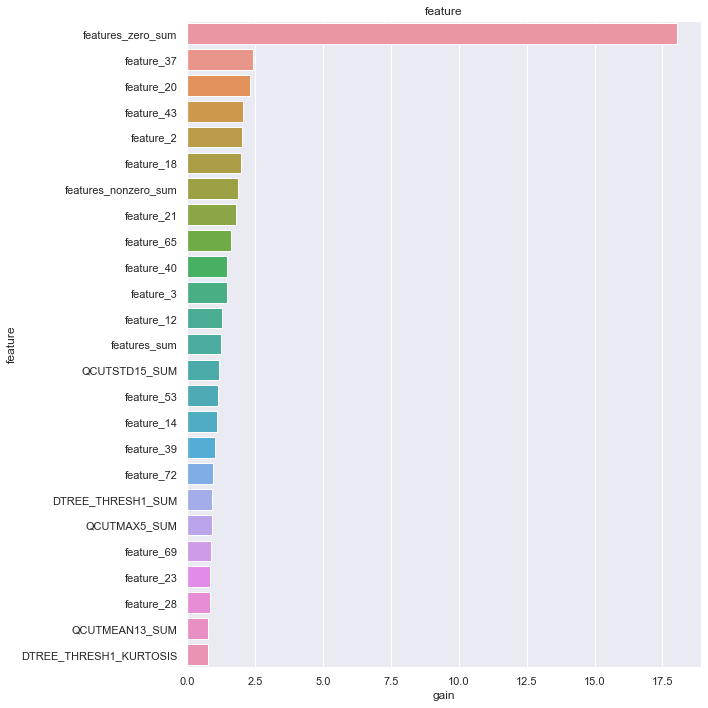

In [20]:
# Feature Importance 
plot_lgb_importances(model, plot=True, num=15)

In [21]:
preds = pd.DataFrame(model.predict_proba(test_x))
preds.columns = list(map(lambda x: "Class_" + str(x+1), preds.columns))
probs = preds.columns.tolist()
preds["id"] = test["id"]
preds = preds[["id"]+probs]
preds

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,200000,0.06,0.42,0.19,0.02,0.01,0.14,0.02,0.04,0.10
1,200001,0.04,0.08,0.08,0.02,0.01,0.26,0.06,0.34,0.11
2,200002,0.02,0.03,0.03,0.01,0.01,0.63,0.04,0.16,0.07
3,200003,0.04,0.10,0.08,0.04,0.01,0.22,0.09,0.26,0.16
4,200004,0.03,0.10,0.08,0.03,0.02,0.32,0.06,0.23,0.14
...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.08,0.38,0.13,0.03,0.02,0.10,0.03,0.07,0.16
99996,299996,0.04,0.26,0.12,0.03,0.02,0.17,0.05,0.15,0.15
99997,299997,0.07,0.27,0.15,0.03,0.01,0.18,0.04,0.10,0.15
99998,299998,0.03,0.02,0.02,0.01,0.01,0.42,0.07,0.33,0.08
